In [372]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
import math
import datetime
import geopandas as gpd
import urllib.request
import requests
import json
import openmeteo_requests
import requests_cache
from shapely.geometry import Polygon, Point
from retry_requests import retry
from shapely.wkt import loads
import random 
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import svm

In [214]:
DATA_DIR_BOMEN = Path("src/data_bomen")
DATA_DIR_GEBOUWEN = Path("src/data_gebouwen")

INCIDENT_DATA_PATH = DATA_DIR_BOMEN / 'Incidenten_oorspronkelijk_volledig.csv'
BOUWJAAR_DATA_PATH = DATA_DIR_GEBOUWEN / 'BOUWJAAR.csv'
ZIPCODE_JSON_PATH = DATA_DIR_BOMEN / "zipcodes_boxes.json"
GRID_SIZE = 200     ## GRID SIZE IN METERS

BUILDING_DATA_CLEAN_PATH = DATA_DIR_GEBOUWEN / f"building_geo_data_clean_{str(GRID_SIZE)}.csv"
GRID_DATA_PATH = DATA_DIR_GEBOUWEN / f"grid_enriched_buildings_{GRID_SIZE}.csv"
INCIDENTS_WEATHER_PATH = DATA_DIR_GEBOUWEN / "Building_incident_with_weather_data.csv"
INCIDENTS_WEATHER_GEO_PATH = DATA_DIR_GEBOUWEN / f"incidents_weather_geo_buildings_{GRID_SIZE}.csv"

POSITIVE_SAMPLES_PATH = DATA_DIR_GEBOUWEN / f"positive_samples_buildings_{GRID_SIZE}.csv"
NEGATIVE_SAMPLES_PATH = DATA_DIR_GEBOUWEN / f"negative_samples_buildings_{GRID_SIZE}.csv"

ZIP_KEY = "Zipcode"
ZIP4_KEY = "Zip4"

DATE_WINDOW = 5

AMSTERDAM_BBOX = (52.26618, 4.64663, 52.475115999999994, 5.150491999999999)

# GRID PATH 200 by 200
GRIDS_200_AMSTERDAM_PATH = Path("src/final_data/grids/grids_200_amsterdam_centered.csv")

In [215]:
BUILDING_COLUMNS = [
    "OBJECTNUMMER",
    "grid_id",
    "Bouwjaar",       
    "WKT_LNG_LAT",
    "WKT_LAT_LNG",
    "LNG",
    "LAT"
]

SERVICE_AREAS_OUT_OF_SCOPE = [
    "Amstelveen",
    "Aalsmeer",
    "Uithoorn"
]

INCIDENT_COLUMNS = [
    "Incident_ID",
    "Service_Area",
    "grid_id",
    "Date",
    "Hour",
    "temperature_2m",
    "relative_humidity_2m",
    "dew_point_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "snow_depth",
    "weather_code",
    "pressure_msl",
    "surface_pressure",
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "soil_temperature_100_to_255cm",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "soil_moisture_100_to_255cm",
]

GRID_COLUMNS = [
    "grid_id",
    "has_building",
    "Gemiddeld Bouwjaar",
    "Gewogen Gemiddeld Bouwjaar",
    "Voor 1860",
    "1860-1919",
    "1920-1939",
    "1940-1969",
    "1970-1985",
    "1986-2001",
    "Na 2001"
]

BUILDING_COLUMNS_MODEL = [
    "building_id",
    "Bouwjaar",
    "bouwjaar_category",     
    "WKT_LNG_LAT",
    "WKT_LAT_LNG",
    "LNG",
    "LAT"
]

In [ ]:
# GRIDS
grids = pd.read_csv(GRIDS_200_AMSTERDAM_PATH, sep=",", encoding="utf-8")
grids = gpd.GeoDataFrame(grids, geometry=gpd.GeoSeries.from_wkt(grids['geometry']))

# INCIDENTS
incidents = pd.read_csv(INCIDENT_DATA_PATH, sep=",", encoding="utf-8")
incidents = incidents.set_index('Incident_ID')

# BUILDINGS
buildings = pd.read_csv(BOUWJAAR_DATA_PATH, sep=";", encoding="utf-8")
buildings['WKT_LNG_LAT'] = buildings['WKT_LNG_LAT'].apply(loads)
buildings['WKT_LAT_LNG'] = buildings['WKT_LAT_LNG'].apply(loads)

# BUILDING INCIDENTS WITH WEATHER DATA
building_incidents_weather = pd.read_csv(INCIDENTS_WEATHER_PATH, sep=",", encoding="utf-8")
building_incidents_weather = building_incidents_weather[~building_incidents_weather.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# BUILDING INCIDENTS WITHOUT WEATHER DATA
building_incidents = incidents[incidents["Damage_Type"]=="Building"]
building_incidents = building_incidents[~building_incidents.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# GEODATAFRAME BUILDINGS
buildings_geo = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(buildings['LNG'], buildings['LAT']), crs="EPSG:4326")
incidents_geo = gpd.GeoDataFrame(building_incidents_weather, geometry=gpd.points_from_xy(building_incidents_weather['LON'], building_incidents_weather['LAT']), crs="EPSG:4326")

# MAP BUILDINGS AND INCIDENTS TO GRID IDS
buildings_geo = gpd.sjoin(buildings_geo, grids, how="left", op="within")
incidents_geo = gpd.sjoin(incidents_geo, grids, how="left", op="within")

buildings_geo = buildings_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})
incidents_geo = incidents_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})

# GET RID OF UNNECESSARY COLUMNS
buildings_geo = buildings_geo[BUILDING_COLUMNS]

def map_bouwjaar_to_category(bouwjaar):
    if bouwjaar < 1860:
        return "Voor 1860"
    elif 1860 <= bouwjaar <= 1919:
        return "1860-1919"
    elif 1920 <= bouwjaar <= 1939:
        return "1920-1939"
    elif 1940 <= bouwjaar <= 1969:
        return "1940-1969"
    elif 1970 <= bouwjaar <= 1985:
        return "1970-1985"
    elif 1986 <= bouwjaar <= 2001:
        return "1986-2001"
    else:
        return "Na 2001"

# BOUWJAAR CATEGORIE MAKEN
buildings_geo['bouwjaar_category'] = buildings_geo['Bouwjaar'].apply(map_bouwjaar_to_category)
buildings_geo['area'] = buildings_geo['WKT_LAT_LNG'].apply(lambda x: x.area)

# ENRICH 
for i in grids.index:
    buildings_geo_sub = buildings_geo[buildings_geo.grid_id == i]
    if len(buildings_geo_sub) > 0:
        grids.at[i, "Gemiddeld Bouwjaar"] = round(np.mean(buildings_geo_sub.Bouwjaar.values), 3)
        weighted_avg_bouwjaar = np.average(buildings_geo_sub.Bouwjaar, weights=buildings_geo_sub.area)
        grids.at[i, "Gewogen Gemiddeld Bouwjaar"] = round(weighted_avg_bouwjaar, 3)
        for name, count in buildings_geo_sub.bouwjaar_category.value_counts().items():
            grids.at[i, "has_building"] = True
            grids.at[i, name] = count
    else:
        grids.at[i, "has_building"] = False
grids.fillna(0, inplace=True)

# SAVE BUILDING AND INCIDENT DATA 
buildings_geo.to_csv(BUILDING_DATA_CLEAN_PATH, sep=",", encoding="utf-8", index=False)
incidents_geo.to_csv(INCIDENTS_WEATHER_GEO_PATH, sep=",", encoding="utf-8", index=False)

# CLEAN AND SAVE GRID DATA
grids = grids.fillna(0)
grids[grids.has_building == True]
grids['grid_id'] = grids.index
grids.to_csv(GRID_DATA_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE POSITIVE SAMPLES
incidents_geo.Date = pd.to_datetime(incidents_geo.Date)
incidents_geo_positive = incidents_geo[INCIDENT_COLUMNS]

grids['grid_id'] = grids.index
grids_positive = grids[GRID_COLUMNS]

buildings_geo = buildings_geo.rename(columns={"OBJECTNUMMER" : "building_id"})
buildings_geo_positive = buildings_geo[BUILDING_COLUMNS_MODEL]

positive_samples = grids_positive.merge(incidents_geo_positive, on='grid_id', how='inner')
positive_samples.to_csv(POSITIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE NEGATIVE SAMPLES WITHOUT WEATHER DATA
def verify_sample(incidents, grid_id, date, window=DATE_WINDOW):
    start_date = date - pd.DateOffset(days=window)
    end_date = date + pd.DateOffset(days=window)

    incidents['Date'] = pd.to_datetime(incidents['Date'])  # Convert 'Date' column to Timestamp

    grids = incidents[(incidents['Date'] >= start_date) & (incidents['Date'] <= end_date)].values
    return False if grid_id not in grids else True

grids_with_building = list(grids[grids.has_building == True].grid_id.values)
negatives = positive_samples[['Date', 'Hour']]
negatives[GRID_COLUMNS] = None

for i, row in negatives.iterrows():
    random_grid = random.sample(grids_with_building, 1)[0]
    while(verify_sample(incidents, random_grid, row.Date)):
        random_grid = random.sample(grids_with_building, 1)[0]
    grid_data = grids[grids.grid_id == random_grid][GRID_COLUMNS].reset_index(drop=True)
    negatives.loc[i, GRID_COLUMNS] = grid_data.iloc[0]

negatives.to_csv(NEGATIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

In [ ]:
GRID_SIZE = 200     ## GRID SIZE IN METERS
DATA_DIR_BOMEN = Path("src/data_bomen")

DATA_DIR_ROADSIGNS= Path("src/data_roadsigns/")
ROADSIGNS_DATA_PATH = DATA_DIR_ROADSIGNS / "verkeersborden_converted_coordinates.csv"
INCIDENTS_WEATHER_PATH =  DATA_DIR_ROADSIGNS / "Roadsign_incident_with_weather_data.csv"
ROADSIGN_DATA_CLEAN_PATH = DATA_DIR_ROADSIGNS / f"roadsign_geo_data_clean_{str(GRID_SIZE)}.csv"
INCIDENTS_WEATHER_GEO_PATH = DATA_DIR_ROADSIGNS / f"incidents_weather_geo_roadsigns_{GRID_SIZE}.csv"
GRID_DATA_PATH = DATA_DIR_ROADSIGNS / f"grid_enriched_roadsigns_{GRID_SIZE}.csv"
INCIDENT_DATA_PATH = DATA_DIR_BOMEN / 'Incidenten_oorspronkelijk_volledig.csv'

POSITIVE_SAMPLES_PATH = DATA_DIR_ROADSIGNS / f"positive_samples_roadsigns_{GRID_SIZE}.csv"
NEGATIVE_SAMPLES_PATH = DATA_DIR_ROADSIGNS / f"negative_samples_roadsigns_{GRID_SIZE}.csv"

ZIP_KEY = "Zipcode"
ZIP4_KEY = "Zip4"

DATE_WINDOW = 5

AMSTERDAM_BBOX = (52.26618, 4.64663, 52.475115999999994, 5.150491999999999)

# GRID PATH 200 by 200
GRIDS_200_AMSTERDAM_PATH = Path("src/final_data/grids/grids_200_amsterdam_centered.csv")

ROADSIGN_COLUMNS = [
    "ondersteuningsconstructie type",
    "grid_id",
    "hoogte onderkant bord",       
    "kijkrichting",
    "LNG",
    "LAT"
]

SERVICE_AREAS_OUT_OF_SCOPE = [
    "Amstelveen",
    "Aalsmeer",
    "Uithoorn"
]

INCIDENT_COLUMNS = [
    "Incident_ID",
    "Service_Area",
    "grid_id",
    "Date",
    "Hour",
    "temperature_2m",
    "relative_humidity_2m",
    "dew_point_2m",
    "apparent_temperature",
    "precipitation",
    "rain",
    "snowfall",
    "snow_depth",
    "weather_code",
    "pressure_msl",
    "surface_pressure",
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "soil_temperature_100_to_255cm",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "soil_moisture_100_to_255cm",
]

# GRIDS
grids = pd.read_csv(GRIDS_200_AMSTERDAM_PATH, sep=",", encoding="utf-8")
grids = gpd.GeoDataFrame(grids, geometry=gpd.GeoSeries.from_wkt(grids['geometry']))

# INCIDENTS
incidents = pd.read_csv(INCIDENT_DATA_PATH, sep=",", encoding="utf-8")
incidents = incidents.set_index('Incident_ID')

# ROAD SIGNS
roadsigns = pd.read_csv(ROADSIGNS_DATA_PATH, sep=",", encoding="utf-8", skipinitialspace = True)
roadsigns = roadsigns.dropna(axis=1, how='all')
columns_to_drop_indices = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21]
roadsigns.drop(roadsigns.columns[columns_to_drop_indices], axis=1, inplace=True)
roadsigns.rename(columns={'latitude': 'LAT', 'longitude': 'LNG'}, inplace=True)

# ROADSIGN INCIDENTS WITH WEATHER DATA
roadsign_incidents_weather = pd.read_csv(INCIDENTS_WEATHER_PATH, sep=",", encoding="utf-8")
roadsign_incidents_weather = roadsign_incidents_weather[~roadsign_incidents_weather.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# ROADSIGN INCIDENTS WITHOUT WEATHER DATA
roadsign_incidents = incidents[incidents["Damage_Type"]=="Fence, Road signs, Scaffolding"]
roadsign_incidents = roadsign_incidents[~roadsign_incidents.Service_Area.isin(SERVICE_AREAS_OUT_OF_SCOPE)]

# GEODATAFRAME ROADSIGNS
roadsigns_geo = gpd.GeoDataFrame(roadsigns, geometry=gpd.points_from_xy(roadsigns['LAT'], roadsigns['LNG']), crs="EPSG:4326")
incidents_geo = gpd.GeoDataFrame(roadsign_incidents_weather, geometry=gpd.points_from_xy(roadsign_incidents_weather['LON'], roadsign_incidents_weather['LAT']), crs="EPSG:4326")

# MAP ROADSIGNS AND INCIDENTS TO GRID IDS
roadsigns_geo = gpd.sjoin(roadsigns_geo, grids, how="left", op="within")
incidents_geo = gpd.sjoin(incidents_geo, grids, how="left", op="within")

roadsigns_geo = roadsigns_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})
incidents_geo = incidents_geo.rename(columns={"index_right" : "grid_id", "geometry" : "location"})

# GET RID OF UNNECESSARY COLUMNS
columns_to_drop_indices = [5,7]
roadsigns_geo.drop(roadsigns_geo.columns[columns_to_drop_indices], axis=1, inplace=True)
columns = ['grid_id'] + [col for col in roadsigns_geo.columns if col != 'grid_id']
roadsigns_geo = roadsigns_geo[columns]

# ENRICH 
roadsigns_geo.iloc[:, 2] = pd.to_numeric(roadsigns_geo.iloc[:, 2], errors='coerce')
roadsigns_geo = roadsigns_geo.dropna(subset=[roadsigns_geo.columns[2]])

roadsigns_geo.iloc[:, 3] = pd.to_numeric(roadsigns_geo.iloc[:, 3], errors='coerce')
roadsigns_geo = roadsigns_geo.dropna(subset=[roadsigns_geo.columns[3]])

for i in grids.index:
    roadsigns_geo_sub = roadsigns_geo[roadsigns_geo.grid_id == i]
    if len(roadsigns_geo_sub) > 0:
        grids.at[i, "Gemiddelde hoogte onderkant bord"] = round(np.mean(roadsigns_geo_sub.iloc[:, [2]].values), 3)
        grids.at[i, "Gemiddelde kijkrichting"] = round(np.mean(roadsigns_geo_sub.iloc[:, [3]].values), 3)
        for name, count in roadsigns_geo_sub.iloc[:, [1]].value_counts().items():
            grids.at[i, "has_roadsign"] = True
            grids.at[i, name] = count
    else:
        grids.at[i, "has_roadsign"] = False
grids.fillna(0, inplace=True)

# SAVE BUILDING AND INCIDENT DATA 
roadsigns_geo.to_csv(ROADSIGN_DATA_CLEAN_PATH, sep=",", encoding="utf-8", index=False)
incidents_geo.to_csv(INCIDENTS_WEATHER_GEO_PATH, sep=",", encoding="utf-8", index=False)

# CLEAN AND SAVE GRID DATA
grids = grids.fillna(0)
grids[grids.has_roadsign == True]
grids['grid_id'] = grids.index
grids.to_csv(GRID_DATA_PATH, sep=",", encoding="utf-8", index=False)

# CREATE AND SAVE POSITIVE SAMPLES
incidents_geo.Date = pd.to_datetime(incidents_geo.Date)
incidents_geo_positive = incidents_geo[INCIDENT_COLUMNS]

grids['grid_id'] = grids.index

columns_to_drop_indices = [0,1]
grids.drop(grids.columns[columns_to_drop_indices], axis=1, inplace=True)
columns = ['grid_id'] + [col for col in grids.columns if col != 'grid_id']
grids_positive = grids[columns]

roadsigns_geo = roadsigns_geo.rename(columns={"OBJECTNUMMER" : "building_id"})
roadsigns_geo_positive = roadsigns_geo.drop(roadsigns_geo.columns[0], axis=1, inplace=True)

positive_samples = grids_positive.merge(incidents_geo_positive, on='grid_id', how='inner')
positive_samples.to_csv(POSITIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

GRID_COLUMNS  =grids.columns

# CREATE AND SAVE NEGATIVE SAMPLES WITHOUT WEATHER DATA
def verify_sample(incidents, grid_id, date, window=DATE_WINDOW):
    start_date = date - pd.DateOffset(days=window)
    end_date = date + pd.DateOffset(days=window)

    incidents['Date'] = pd.to_datetime(incidents['Date'])  # Convert 'Date' column to Timestamp

    grids = incidents[(incidents['Date'] >= start_date) & (incidents['Date'] <= end_date)].values
    return False if grid_id not in grids else True

grids_with_roadsign = list(grids[grids.has_roadsign == True].grid_id.values)
negatives = positive_samples[['Date', 'Hour']]
negatives[GRID_COLUMNS] = None

for i, row in negatives.iterrows():
    random_grid = random.sample(grids_with_roadsign, 1)[0]
    while(verify_sample(incidents, random_grid, row.Date)):
        random_grid = random.sample(grids_with_roadsign, 1)[0]
    grid_data = grids[grids.grid_id == random_grid][GRID_COLUMNS].reset_index(drop=True)
    negatives.loc[i, GRID_COLUMNS] = grid_data.iloc[0]

negatives.to_csv(NEGATIVE_SAMPLES_PATH, sep=",", encoding="utf-8", index=False)

In [92]:
# IMPORT NEGATIVES
NEGATIVES = pd.read_csv(r'src\data_gebouwen\negative_samples_buildings_200.csv')
GRIDS_200_AMSTERDAM_PATH = Path("src/final_data/grids/grids_200_amsterdam_centered.csv")
GRIDS = pd.read_csv(GRIDS_200_AMSTERDAM_PATH)

GRIDS['geometry'] = GRIDS['geometry'].apply(loads)
gGRIDS = gpd.GeoDataFrame(GRIDS, geometry='geometry')
centroids = gGRIDS['geometry'].centroid
lon, lat = centroids.x, centroids.y
GRIDS['LON'] = lon
GRIDS['LAT'] = lat

NEGATIVES['Date'] = pd.to_datetime(NEGATIVES['Date'])
NEGATIVES['Date'] = NEGATIVES['Date'].dt.strftime('%Y-%m-%d')
GRIDS = GRIDS.rename(columns={"Unnamed: 0": "grid_id"})

NEGATIVES = pd.merge(NEGATIVES, GRIDS[['grid_id', 'LON', 'LAT']], on='grid_id', how='left')

# Split the DataFrame into 10 smaller DataFrames
num_splits = 15
NEGATIVES_splits = np.array_split(NEGATIVES, num_splits)

C:\Users\Aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [93]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
split = 14

temperature_2m_list = []
relative_humidity_2m_list = []
dew_point_2m_list = []
apparent_temperature_list = []
precipitation_list = []
rain_list = []
snowfall_list = []
snow_depth_list = []
weather_code_list = []
pressure_msl_list = []
surface_pressure_list = []
cloud_cover_list = []
cloud_cover_low_list = []
cloud_cover_mid_list = []
cloud_cover_high_list = []
et0_fao_evapotranspiration_list = []
vapour_pressure_deficit_list = []
wind_speed_10m_list = []
wind_speed_100m_list = []
wind_direction_10m_list = []
wind_direction_100m_list = []
wind_gusts_10m_list = []
soil_temperature_0_to_7cm_list = []
soil_temperature_7_to_28cm_list = []
soil_temperature_28_to_100cm_list = []
soil_temperature_100_to_255cm_list = []
soil_moisture_0_to_7cm_list = []
soil_moisture_7_to_28cm_list = []
soil_moisture_28_to_100cm_list = []
soil_moisture_100_to_255cm_list = []

for i, row in NEGATIVES_splits[split].iterrows():
    latitude = row['LAT']
    longitude = row['LON']
    dateStr = row['Date']
    timeStr = row['Hour']

    latitude='{:.5f}'.format(latitude)
    longitude='{:.5f}'.format(longitude)

    
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": dateStr,
        "end_date": dateStr,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "et0_fao_evapotranspiration", "vapour_pressure_deficit", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_temperature_100_to_255cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", "soil_moisture_100_to_255cm"]
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    temperature_2m = hourly.Variables(0).ValuesAsNumpy()[int(timeStr)]
    relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()[int(timeStr)]
    dew_point_2m = hourly.Variables(2).ValuesAsNumpy()[int(timeStr)]
    apparent_temperature = hourly.Variables(3).ValuesAsNumpy()[int(timeStr)]
    precipitation = hourly.Variables(4).ValuesAsNumpy()[int(timeStr)]
    rain = hourly.Variables(5).ValuesAsNumpy()[int(timeStr)]
    snowfall = hourly.Variables(6).ValuesAsNumpy()[int(timeStr)]
    snow_depth = hourly.Variables(7).ValuesAsNumpy()[int(timeStr)]
    weather_code = hourly.Variables(8).ValuesAsNumpy()[int(timeStr)]
    pressure_msl = hourly.Variables(9).ValuesAsNumpy()[int(timeStr)]
    surface_pressure = hourly.Variables(10).ValuesAsNumpy()[int(timeStr)]
    cloud_cover = hourly.Variables(11).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_low = hourly.Variables(12).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_mid = hourly.Variables(13).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_high = hourly.Variables(14).ValuesAsNumpy()[int(timeStr)]
    et0_fao_evapotranspiration = hourly.Variables(15).ValuesAsNumpy()[int(timeStr)]
    vapour_pressure_deficit = hourly.Variables(16).ValuesAsNumpy()[int(timeStr)]
    wind_speed_10m = hourly.Variables(17).ValuesAsNumpy()[int(timeStr)]
    wind_speed_100m = hourly.Variables(18).ValuesAsNumpy()[int(timeStr)]
    wind_direction_10m = hourly.Variables(19).ValuesAsNumpy()[int(timeStr)]
    wind_direction_100m = hourly.Variables(20).ValuesAsNumpy()[int(timeStr)]
    wind_gusts_10m = hourly.Variables(21).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_0_to_7cm = hourly.Variables(22).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_7_to_28cm = hourly.Variables(23).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_28_to_100cm = hourly.Variables(24).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_100_to_255cm = hourly.Variables(25).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_0_to_7cm = hourly.Variables(26).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_7_to_28cm = hourly.Variables(27).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_28_to_100cm = hourly.Variables(28).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_100_to_255cm = hourly.Variables(29).ValuesAsNumpy()[int(timeStr)]
    

    temperature_2m_list.append(temperature_2m)
    relative_humidity_2m_list.append(relative_humidity_2m)
    dew_point_2m_list.append(dew_point_2m)
    apparent_temperature_list.append(apparent_temperature)
    precipitation_list.append(precipitation)
    rain_list.append(rain)
    snowfall_list.append(snowfall)
    snow_depth_list.append(snow_depth)
    weather_code_list.append(weather_code)
    pressure_msl_list.append(pressure_msl)
    surface_pressure_list.append(surface_pressure)
    cloud_cover_list.append(cloud_cover)
    cloud_cover_low_list.append(cloud_cover_low)
    cloud_cover_mid_list.append(cloud_cover_mid)
    cloud_cover_high_list.append(cloud_cover_high)
    et0_fao_evapotranspiration_list.append(et0_fao_evapotranspiration)
    vapour_pressure_deficit_list.append(vapour_pressure_deficit)
    wind_speed_10m_list.append(wind_speed_10m)
    wind_speed_100m_list.append(wind_speed_100m)
    wind_direction_10m_list.append(wind_direction_10m)
    wind_direction_100m_list.append(wind_direction_100m)
    wind_gusts_10m_list.append(wind_gusts_10m)
    soil_temperature_0_to_7cm_list.append(soil_temperature_0_to_7cm)
    soil_temperature_7_to_28cm_list.append(soil_temperature_7_to_28cm)
    soil_temperature_28_to_100cm_list.append(soil_temperature_28_to_100cm)
    soil_temperature_100_to_255cm_list.append(soil_temperature_100_to_255cm)
    soil_moisture_0_to_7cm_list.append(soil_moisture_0_to_7cm)
    soil_moisture_7_to_28cm_list.append(soil_moisture_7_to_28cm)
    soil_moisture_28_to_100cm_list.append(soil_moisture_28_to_100cm)
    soil_moisture_100_to_255cm_list.append(soil_moisture_100_to_255cm)


# Assign lists as new columns to the DataFrame
NEGATIVES_splits[split]['temperature_2m'] = temperature_2m_list
NEGATIVES_splits[split]['relative_humidity_2m'] = relative_humidity_2m_list
NEGATIVES_splits[split]['dew_point_2m'] = dew_point_2m_list
NEGATIVES_splits[split]['apparent_temperature'] = apparent_temperature_list
NEGATIVES_splits[split]['precipitation'] = precipitation_list
NEGATIVES_splits[split]['rain'] = rain_list
NEGATIVES_splits[split]['snowfall'] = snowfall_list
NEGATIVES_splits[split]['snow_depth'] = snow_depth_list
NEGATIVES_splits[split]['weather_code'] = weather_code_list
NEGATIVES_splits[split]['pressure_msl'] = pressure_msl_list
NEGATIVES_splits[split]['surface_pressure'] = surface_pressure_list
NEGATIVES_splits[split]['cloud_cover'] = cloud_cover_list
NEGATIVES_splits[split]['cloud_cover_low'] = cloud_cover_low_list
NEGATIVES_splits[split]['cloud_cover_mid'] = cloud_cover_mid_list
NEGATIVES_splits[split]['cloud_cover_high'] = cloud_cover_high_list
NEGATIVES_splits[split]['et0_fao_evapotranspiration'] = et0_fao_evapotranspiration_list
NEGATIVES_splits[split]['vapour_pressure_deficit'] = vapour_pressure_deficit_list
NEGATIVES_splits[split]['wind_speed_10m'] = wind_speed_10m_list
NEGATIVES_splits[split]['wind_speed_100m'] = wind_speed_100m_list
NEGATIVES_splits[split]['wind_direction_10m'] = wind_direction_10m_list
NEGATIVES_splits[split]['wind_direction_100m'] = wind_direction_100m_list
NEGATIVES_splits[split]['wind_gusts_10m'] = wind_gusts_10m_list
NEGATIVES_splits[split]['soil_temperature_0_to_7cm'] = soil_temperature_0_to_7cm_list
NEGATIVES_splits[split]['soil_temperature_7_to_28cm'] = soil_temperature_7_to_28cm_list
NEGATIVES_splits[split]['soil_temperature_28_to_100cm'] = soil_temperature_28_to_100cm_list
NEGATIVES_splits[split]['soil_temperature_100_to_255cm'] = soil_temperature_100_to_255cm_list
NEGATIVES_splits[split]['soil_moisture_0_to_7cm'] = soil_moisture_0_to_7cm_list
NEGATIVES_splits[split]['soil_moisture_7_to_28cm'] = soil_moisture_7_to_28cm_list
NEGATIVES_splits[split]['soil_moisture_28_to_100cm'] = soil_moisture_28_to_100cm_list
NEGATIVES_splits[split]['soil_moisture_100_to_255cm'] = soil_moisture_100_to_255cm_list

NEGATIVES_splits[split]

In [ ]:
combined_incs = pd.concat(NEGATIVES_splits, ignore_index=True)
combined_incs

# XGBOOST

In [309]:
# XGBOOST 
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/buildings/positive_samples_buildings_200.csv")
NEGATIVES_PATH = Path("src/final_data/buildings/negative_samples_buildings_200.csv")

# POSITIVE SAMPLE BUILDINGS
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE BUILDINGS
NEGATIVES = pd.read_csv(NEGATIVES_PATH)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES['label'] = 0

# COMMON COLUMNS
common_columns = ['grid_id', 'has_building', 'Gemiddeld Bouwjaar',
       'Gewogen Gemiddeld Bouwjaar', 'Voor 1860', '1860-1919', '1920-1939',
       '1940-1969', '1970-1985', '1986-2001', 'Na 2001', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm']

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns + ['label']],
                  NEGATIVES[common_columns + ['label']]])
DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]


X, y = DATA.drop(['label',
                  'grid_id',
                  'Gemiddeld Bouwjaar'], axis=1), DATA[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype('category')

X = X[[#'has_building', 
       'Gewogen Gemiddeld Bouwjaar', 
       #'wind_direction_10m', 
       'wind_gusts_10m'
       ]]

y.columns

Index(['label'], dtype='object')

In [310]:
# SPLIT THE DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [311]:
# CREATING CLASSIFICATION MATRICES
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

# DEFINING HYPERPARAMETERS
params = {"objective": "binary:logistic", 'eval_metric': 'auc'}
n = 1000

# MODEL TRAINING
model = xgb.train(
    params = params,
    dtrain = dtrain_clf, 
    num_boost_round = n, 
    verbose_eval = 250, 
    evals=evals,
    early_stopping_rounds=50
)

[0]	train-auc:0.74906	validation-auc:0.70027
[56]	train-auc:0.91105	validation-auc:0.70397


In [312]:
y_pred_clf = model.predict(dtest_clf)
y_pred_labels = (y_pred_clf > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
percentage_correct = accuracy * 100

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


Percentage of correctly classified labels: 67.02%


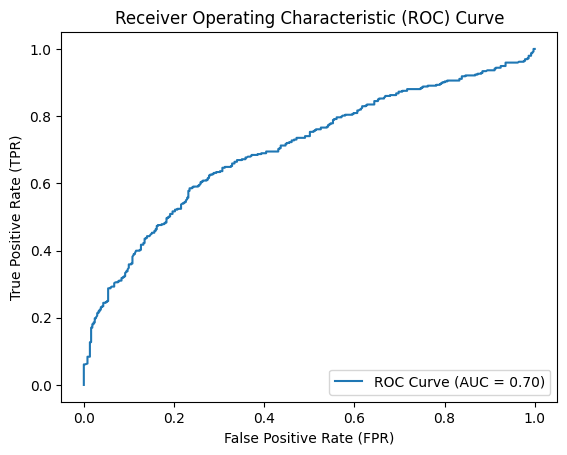

In [313]:
# ROC Curve
y_pred_clf = model.predict(dtest_clf)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

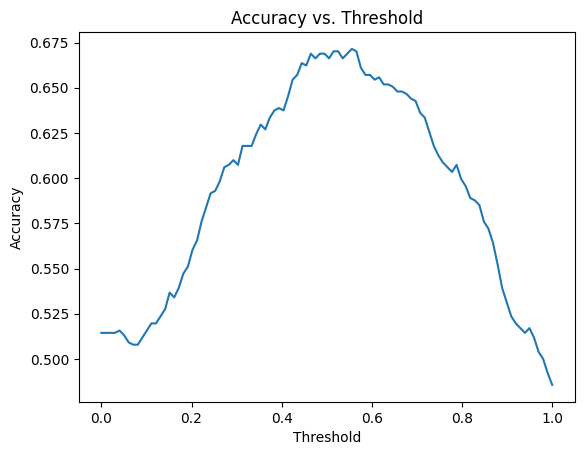

In [302]:
thresholds = np.linspace(0, 1, 100)
accuracies = []
for threshold in thresholds:
    y_pred_labels = (y_pred_clf > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_labels)
    accuracies.append(accuracy)

plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()


# LOGISTIC REGRESSION

In [356]:
# LOGISTIC REGRESSION
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/buildings/positive_samples_buildings_200.csv")
NEGATIVES_PATH = Path("src/final_data/buildings/negative_samples_buildings_200.csv")

# POSITIVE SAMPLE BUILDINGS
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE BUILDINGS
NEGATIVES = pd.read_csv(NEGATIVES_PATH)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES['label'] = 0

# COMMON COLUMNS
common_columns = ['grid_id', 'has_building', 'Gemiddeld Bouwjaar',
       'Gewogen Gemiddeld Bouwjaar', 'Voor 1860', '1860-1919', '1920-1939',
       '1940-1969', '1970-1985', '1986-2001', 'Na 2001', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm']

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns + ['label']],
                  NEGATIVES[common_columns + ['label']]])
DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]


X, y = DATA.drop(['label',
                  'grid_id',
                  'Gemiddeld Bouwjaar'], axis=1), DATA[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype('category')

X = X[[#'has_building', 
       'Gewogen Gemiddeld Bouwjaar', 
       'wind_direction_10m', 
       'wind_gusts_10m'
       ]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [357]:
# INSTANTIATE THE MODEL
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [363]:
accuracy = accuracy_score(y_test, y_pred)
percentage_correct = accuracy * 100

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


Percentage of correctly classified labels: 68.19%


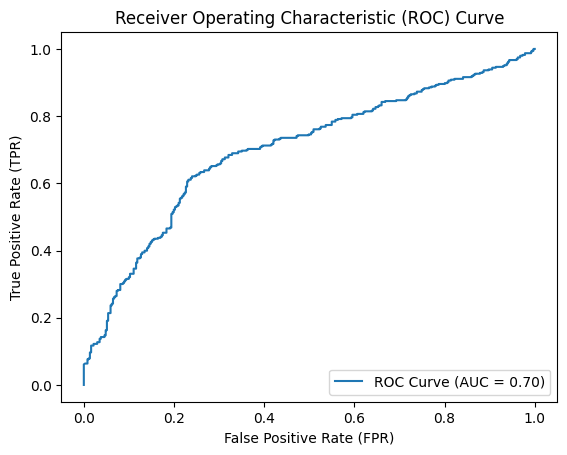

In [368]:
# Assuming y_test and y_pred_clf are already defined
y_pred_clf = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)

# Plotting the ROC curve
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


# SUPPORT VECTOR MACHINE (SVM)

In [379]:
# LOGISTIC REGRESSION
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/buildings/positive_samples_buildings_200.csv")
NEGATIVES_PATH = Path("src/final_data/buildings/negative_samples_buildings_200.csv")

# POSITIVE SAMPLE BUILDINGS
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE BUILDINGS
NEGATIVES = pd.read_csv(NEGATIVES_PATH)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES['label'] = 0

# COMMON COLUMNS
common_columns = ['grid_id', 'has_building', 'Gemiddeld Bouwjaar',
       'Gewogen Gemiddeld Bouwjaar', 'Voor 1860', '1860-1919', '1920-1939',
       '1940-1969', '1970-1985', '1986-2001', 'Na 2001', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'wind_speed_10m',
       'wind_direction_10m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm']

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns + ['label']],
                  NEGATIVES[common_columns + ['label']]])
DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]


X, y = DATA.drop(['label',
                  'grid_id',
                  'Gemiddeld Bouwjaar'], axis=1), DATA[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype('category')

X = X[[#'has_building', 
       'Gewogen Gemiddeld Bouwjaar', 
       'wind_direction_10m', 
       'wind_gusts_10m'
       ]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 

In [383]:
POSITIVES['Gewogen Gemiddeld Bouwjaar'].describe(), NEGATIVES['Gewogen Gemiddeld Bouwjaar'].describe()

(count    1528.000000
 mean     1844.824618
 std       404.318537
 min         0.000000
 25%      1886.126000
 50%      1928.487000
 75%      1975.256750
 max      2018.000000
 Name: Gewogen Gemiddeld Bouwjaar, dtype: float64,
 count    1528.000000
 mean     1966.179863
 std        38.673793
 min      1850.000000
 25%      1950.000000
 50%      1976.689000
 75%      1994.007500
 max      2018.000000
 Name: Gewogen Gemiddeld Bouwjaar, dtype: float64)

In [376]:
# MODEL TRAINING
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [377]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6993464052287581
